# Exploring Metabolic Interactions among Marine Microbes

The intricate web of metabolic interactions among marine microbes plays a pivotal role in regulating the biogeochemical cycles of our oceans. These microbial communities work synergistically, exchanging metabolites and co-contributing to the nutrient dynamics of marine ecosystems. However, understanding the precise nature and scope of these interactions at a metabolic level can be challenging.

[Smetana](https://www.pnas.org/doi/abs/10.1073/pnas.1421834112) is a computational tool designed to unearth metabolic interactions among microbial communities. To this end, it employs genome-scale metabolic models and a defined medium to predict potential metabolic exchanges and synergistic relationships among microbes, thus offering a mechanisnic insight into the metabolic interactions occurring within a microbial community.

In this Jupyter Notebook, we will employ the Python [implementation](https://github.com/cdanielmachado/smetana) of Smetana to find putative metabolic interactions among a set of microbes. Specifically, we will use reconstructed models of the genera: _Sulfitobacter sp._, _Alteromonas sp._, _Marinobacter sp._, and _Polaribacter sp_, which were previously reconstructed using [CarveME](https://github.com/cdanielmachado/carveme) and MAGs from the [TARA Oceans](http://ocean-microbiome.embl.de/companion.html) dataset.


In [1]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from phycogem.visualization import get_graph_object_from_smetana_table
from phycogem.reconstruction_helpers import get_medium_dict_from_media_db, get_dict_of_metabolite_ids

## Running Smetana

Smetana is a command-line tool, so we will run it in a "bash" cell. Besides the models, we will need to provide a medium file, which will be used to simulate the growth of the microbes. In this case, we will use a marine medium containing inorganic components, a carbon source and some cofactors. Here is the complete list of components:

In [2]:
met_names = get_dict_of_metabolite_ids("../data/compounds/BIGG_metabolites.json")
medium = get_medium_dict_from_media_db(
    "../data/marine_media/media_db.tsv",
    "M9[marine]")

for rxn_ex in medium:
    met_id = "_".join("_".join(rxn_ex.split("_")[1:]).split("_")[:-1])
    print(f"{met_id}: {met_names[met_id]}")

ca2: Calcium
cl: Chloride
cobalt2: Co2+
cu2: Copper
fe2: Fe2+ mitochondria
fe3: Iron (Fe3+)
glc__D: D-Glucose
h2o: H2O H2O
h: H+
k: Potassium
mg2: Magnesium
mn2: Manganese
mobd: Molybdate
na1: Sodium
nh4: Ammonium
ni2: Nickel
o2: O2 O2
pi: Phosphate
so4: Sulfate
zn2: Zinc
photon: Light
co: Carbon monoxide
co2: CO2 CO2
n2: Nitrogen
hco3: Bicarbonate


We are now ready to run Smetana to find putative metabolic interactions. Smetana needs to solve several Mixed-Integer Linear Programs (MILPs) to predict metabolic exchanges. To this end, we will employ Gurobi as the MILP solver, although other solvers, like GLPK may be employed.

In [2]:
%%bash

smetana \
    ../results/models/TARA_ARC_108*.xml \
    -m M9[marine] \
    --mediadb ../data/marine_media/media_db.tsv \
    -o ../results/bacterial_interactions \
    --solver gurobi \
    --detailed

## Displaying interactions

Now that we have run Smetana, we can display the predicted metabolic interactions as a directed [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph). First, let's assign taxonomy to model names and convert and format metabolite names to make the graph more readable.

In [3]:
df = pd.read_csv(
    "../results/bacterial_interactions_detailed.tsv",
    sep="\t"
    )
mag_tax = {
    "TARA_ARC_108_MAG_00080.genepred": "Alteromonas sp.",
    "TARA_ARC_108_MAG_00174.genepred": "Marinobacter sp.",
    "TARA_ARC_108_MAG_00117.genepred": "Sulfitobacter sp. 1",
    "TARA_ARC_108_MAG_00139.genepred": "Sulfitobacter sp. 2",
}
df.donor = df.donor.apply(lambda x: mag_tax[x])
df.receiver = df.receiver.apply(lambda x: mag_tax[x])
df.compound = df.compound.apply(lambda x: "_".join(x.split("_")[1:]))
df.head()


,community,medium,receiver,donor,compound,scs,mus,mps,smetana
0,all,M9[marine],Sulfitobacter sp. 1,Alteromonas sp.,fe3pyovd_kt_e,0.5,0.39,1,0.195
1,all,M9[marine],Sulfitobacter sp. 1,Alteromonas sp.,nadp_e,0.5,0.80,1,0.400
2,all,M9[marine],Sulfitobacter sp. 1,Alteromonas sp.,thm_e,0.5,1.00,1,0.500
3,all,M9[marine],Sulfitobacter sp. 1,Marinobacter sp.,alaala_e,0.5,0.89,1,0.445
4,all,M9[marine],Sulfitobacter sp. 1,Marinobacter sp.,fe3pyovd_kt_e,0.5,0.39,1,0.195


We then will build a [networkx](https://networkx.github.io/) graph object and display the interactions. Note, that a bipartite graph contains two sets of nodes and edges can only connect nodes from different sets. In this case, we have two sets of nodes: models (genera) and metabolites. Model nodes are colored in blue, while exchanged metabolites in pink. Arrows represent the direction of the exchange and the wight of the edge represent the smetana score of the interaction. Briefly, the smetana score is a measure of the likelihood of an interaction to occur, with higher scores indicating more likely interactions.

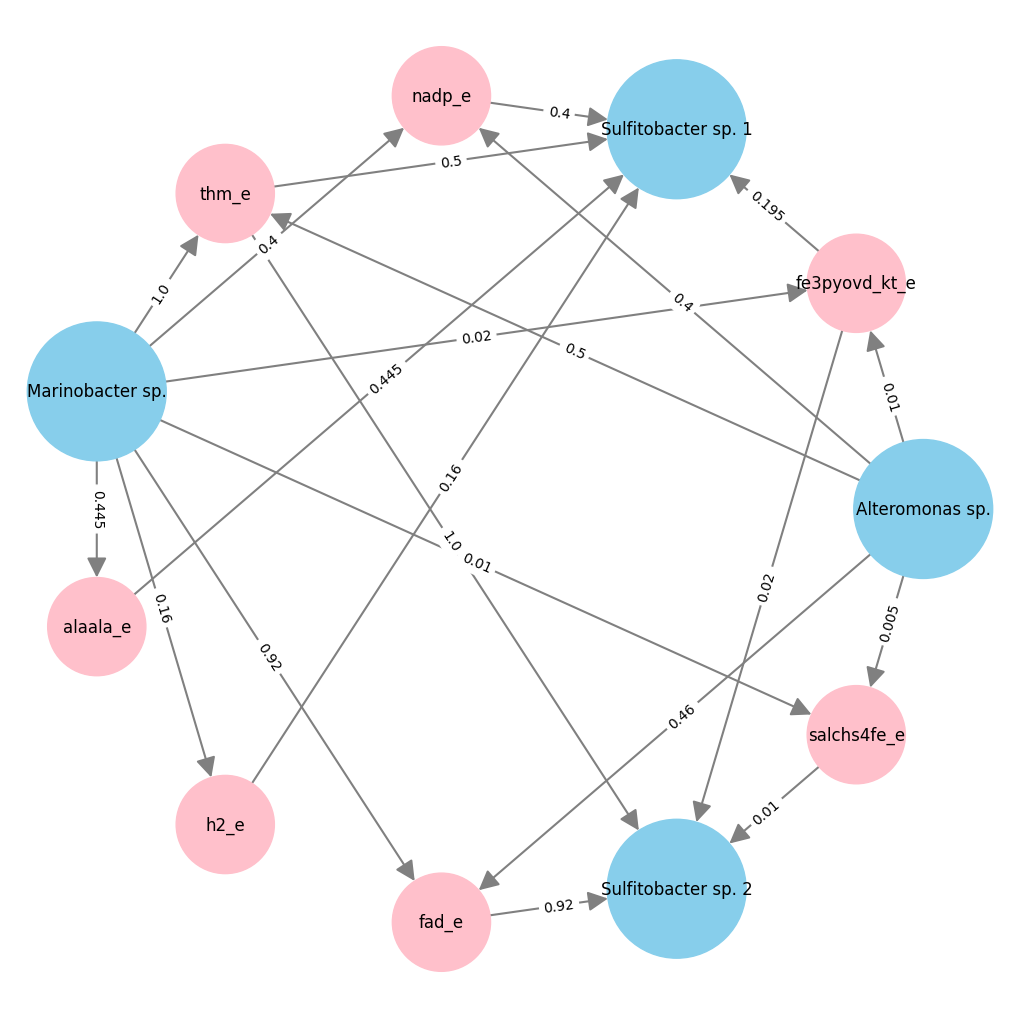

In [10]:
bipartite_graph = get_graph_object_from_smetana_table(
    df,
    output_graph="../results/graphs/graph.json",
    weight="smetana"
    )

large_node_size = 10000
small_node_size = 5000
plt.figure(figsize=(10, 10))

nx.draw(
    bipartite_graph,
    nx.circular_layout(bipartite_graph),
    with_labels=True,
    node_size=[
        large_node_size if bipartite == 0 else small_node_size
        for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()
    ],
    node_color=[
        'skyblue' if bipartite == 0 else 'pink'
        for bipartite in nx.get_node_attributes(bipartite_graph, 'bipartite').values()
    ],
    edge_color='gray',
    arrowsize=30,
    width=1.5
)
nx.draw_networkx_edge_labels(
    bipartite_graph,
    nx.circular_layout(bipartite_graph),
    edge_labels=nx.get_edge_attributes(bipartite_graph, 'weight'),
)
plt.show()

## Conclusions

Here you go! We have successfully used Smetana to predict metabolic interactions among a set of marine microbes. As you can see, Smetana is a powerful tool to predict metabolic interactions among microbes, which can be used to reconstruct metabolic networks of microbial communities and to gain insights into the metabolic dynamics of marine ecosystems.